In [3]:
# import
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from utils import jarque_bera_p_value, adf_p_value

In [4]:
# all data
dia_df = pd.read_csv("data/DIA.csv")
qqq_df = pd.read_csv("data/QQQ.csv")
spy_df = pd.read_csv("data/SPY.csv")

# adding suffix to all df
dia_df.columns=dia_df.columns.map(lambda x : x+'_dia' if x !='Date' else x)
qqq_df.columns=qqq_df.columns.map(lambda x : x+'_qqq' if x !='Date' else x)
spy_df.columns=spy_df.columns.map(lambda x : x+'_spy' if x !='Date' else x)

In [5]:
dfs = [dia_df, qqq_df, spy_df]

df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

# set date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
Training_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
Test_df = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
Out_of_sample_df = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

# Figure 1

In [6]:
ETF_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()

In [7]:
ETF_df

,Close_dia,Close_qqq,Close_spy
Date,,,
2011-01-03,116.410004,55.310001,127.050003
2011-01-04,116.639999,55.270000,126.980003
2011-01-05,117.040001,55.740002,127.639999
2011-01-06,116.779999,55.919998,127.389999
2011-01-07,116.570000,55.869999,127.139999
...,...,...,...
2015-04-07,178.419998,105.800003,207.279999
2015-04-08,178.750000,106.639999,207.979996
2015-04-09,179.399994,107.309998,208.899994


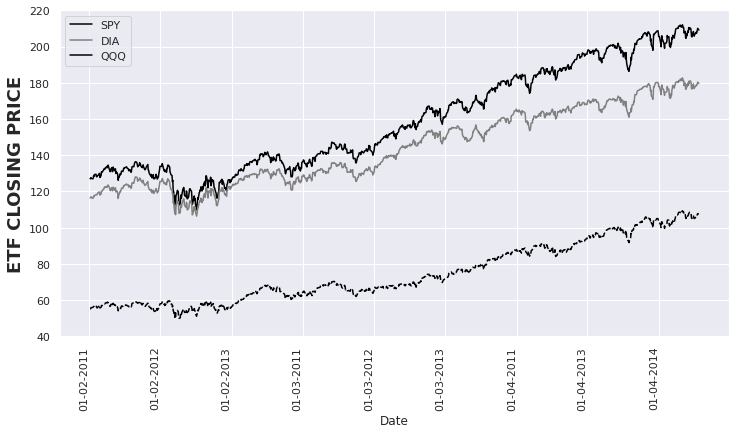

In [8]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(x=ETF_df.index, y='Close_spy', data=ETF_df, label="SPY", color='black')
sns.lineplot(x=ETF_df.index, y='Close_dia', data=ETF_df, label="DIA", color='grey')
sns.lineplot(x=ETF_df.index, y='Close_qqq', data=ETF_df, label="QQQ", color='black')

ax.lines[2].set_linestyle("--")

ax.set_ylabel('ETF CLOSING PRICE', fontsize=18, fontweight='bold')
ax.set(ylim=(40, 220))

x_dates = ETF_df.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');

plt.savefig('table/Figure1.png')

# Table 2

In [9]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                                     'STD':Adj_close_stats_df.apply(np.std),
                                     'Skew':Adj_close_stats_df.apply(skew),
                                     'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                                     'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False)),
#                                      'Jarque-Bera_t_stat':Adj_close_stats_df.apply(jarque_bera_t_stat),
                                     'Jarque-Bera_p_value':Adj_close_stats_df.apply(jarque_bera_p_value),
#                                      'ADF_t_stat':Adj_close_stats_df.apply(adf_t_stat),
                                     'ADF_p_value':Adj_close_stats_df.apply(adf_p_value)})
Table2 = Adj_close_Table.transpose()[['SPY', 'DIA', 'QQQ']]

Table2.to_csv("table/Table2.csv", index=True)
Table2

,SPY,DIA,QQQ
Mean,5.443915e-04,4.971633e-04,6.659312e-04
STD,9.592380e-03,8.863505e-03,1.052343e-02
Skew,-5.687756e-01,-5.178219e-01,-4.048366e-01
Fisher_Kurtosis,5.238305e+00,4.371469e+00,3.177268e+00
Pearson_Kurtosis,8.238305e+00,7.371469e+00,6.177268e+00
Jarque-Bera_p_value,0.000000e+00,0.000000e+00,0.000000e+00
ADF_p_value,6.154752e-30,8.649508e-30,7.087245e-19


In [7]:
# Correlation matrix (Spearman's rank)
Spearman_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="spearman")

Spearman_corr.to_csv("table/Spearman_correlation.csv", index=True)
Spearman_corr

,SPY,DIA,QQQ
SPY,1.000000,0.955254,0.887686
DIA,0.955254,1.000000,0.805231
QQQ,0.887686,0.805231,1.000000


In [8]:
# Correlation matrix (Pearson's method)
Pearson_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="pearson")

Pearson_corr.to_csv("table/Pearson_correlation.csv", index=True)
Pearson_corr

,SPY,DIA,QQQ
SPY,1.000000,0.972872,0.926548
DIA,0.972872,1.000000,0.871434
QQQ,0.926548,0.871434,1.000000


# Table 3

In [117]:
# Table 3
datasets = ["Total data-set", "Training data-set", "Test data-set", "Out-of-sample data-set"]
trading_days = [len(Total_df), len(Training_df), len(Test_df), len(Out_of_sample_df)]
start_date = [Total_df.index[0].strftime('%d/%m/%Y'), Training_df.index[0].strftime('%d/%m/%Y'), Test_df.index[0].strftime('%d/%m/%Y'), Out_of_sample_df.index[0].strftime('%d/%m/%Y')]
end_date = [Total_df.index[-1].strftime('%d/%m/%Y'), Training_df.index[-1].strftime('%d/%m/%Y'), Test_df.index[-1].strftime('%d/%m/%Y'), Out_of_sample_df.index[-1].strftime('%d/%m/%Y')]

Table3 = pd.DataFrame({"Datasets":datasets, "Trading days":trading_days, "Start date":start_date, "End date": end_date})

Table3.to_csv("table/Table3.csv", index=False)
Table3

,Datasets,Trading days,Start date,End date
0,Total data-set,1075,03/01/2011,13/04/2015
1,Training data-set,502,03/01/2011,31/12/2012
2,Test data-set,252,02/01/2013,31/12/2013
3,Out-of-sample data-set,321,02/01/2014,13/04/2015
